In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dask import delayed

In [15]:
def simulation(N,p,gamma,steps,dt):
    J = p[:N*N].reshape((N,N))     
    np.fill_diagonal(J,0)          
    h = p[N*N:]                    
    
    S = [np.random.randint(0,2,N)*2-1]

    for i in tqdm(range(1,steps)):
        s = np.copy(S[-1])
        H = h + np.dot(J,s)
        p_flip = gamma*dt*0.5*(1-s*np.tanh(H))
        p = np.random.rand(N)
        s[p<p_flip]*=-1
        S.append(s)
    S = np.array(S).T
    return S.astype('float')

def C_and_Cdot(S,dt):
    N = S.shape[0]
    C = np.dot(S, S.T)/S.shape[1]
    C_dot = np.dot(S[:,1:], S[:,:-1].T)/(S.shape[1]-1)
    C_dot -= C
    C_dot /= dt
        
    return C,C_dot      

def grad_L(p,S,C,C_dot,gamma):
    N_t = S.shape[1]
    N = S.shape[0]
    
    # p are the params, S is the spins history
    J = p[:N*N].reshape((N,N))     # NxN matrix
    np.fill_diagonal(J,0)          #removing the diagonal terms for easier sums
    h = p[N*N:]                    # N vector
    
    #grad wrt h
    H = (h + np.dot(J,S).T).T
    G_1 = np.mean(S-np.tanh(H),axis=1)
    
    #grad wrt J
    G_0 = C_dot/gamma + C
    G_0 -= (np.dot(np.tanh(H),S.T))/N_t
    
    #new
    np.fill_diagonal(G_0,0)
    return np.concatenate((G_0.flatten(),G_1))
    
def parralel_grad(p,S_split,C,C_dot,gamma):
    ris = []
    for S in S_split:
        ris.append(delayed(grad_L)(p,S,C,C_dot,gamma))
    grad = delayed(sum)(ris).compute()/len(S_split)
    return grad

## 100 spins and 100000 steps

In [16]:
np.random.seed(201098)

N = 100
#########################################
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)

p_real = np.concatenate((J.flatten(),h))
##########################################
gamma = 1
steps = 100_000
dt = 0.1
##########################################
##SIMULATION
np.random.seed(12345)
S = simulation(N,p_real,gamma,steps,dt)


C,C_dot = C_and_Cdot(S,dt)
#-----------------------n cores------------------------------------#
n_cores = 5 #10 is the best

S_split = np.array_split(S,n_cores,axis = 1)
#del S

100%|██████████| 99999/99999 [00:05<00:00, 16993.08it/s]


In [17]:
%time _ = parralel_grad(p_real,S_split,C,C_dot,gamma)
%time _ = grad_L(p_real,S,C,C_dot,gamma)

CPU times: user 2.9 s, sys: 7.87 s, total: 10.8 s
Wall time: 348 ms
CPU times: user 2.21 s, sys: 3.74 s, total: 5.94 s
Wall time: 662 ms


### Optimization

### GA with momentum

100%|██████████| 400/400 [02:06<00:00,  3.15it/s]


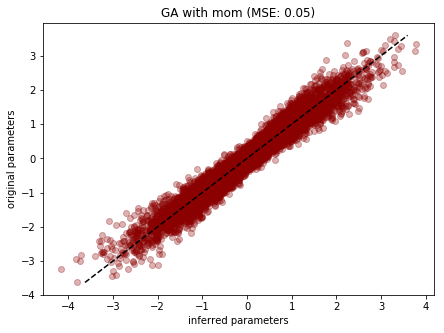

In [18]:
np.random.seed(2010)
p_mom = np.random.normal(0,1,N*N+N)
v = np.zeros(N*N+N)
### PARAMS
Steps = 400
l_r = np.linspace(0.1,0.001,Steps)
fric = 0.9

for i in tqdm(range(Steps)):
    g = parralel_grad(p_mom,S_split,C,C_dot,gamma)
    v = fric*v + l_r[i] * g
    p_mom += v
      
plt.figure(figsize=(7,5))
plt.plot(p_mom,p_real,'o',alpha = 0.3,color='darkred')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='black')
plt.title('GA with mom (MSE: '+str(np.mean((p_mom-p_real)**2))[:4]+')')
plt.xlabel("inferred parameters")
plt.ylabel("original parameters")
plt.savefig('01.png',dpi=200)

### RMS PROP + regularization

100%|██████████| 400/400 [02:04<00:00,  3.22it/s]


MSE:  1415.7395482194293


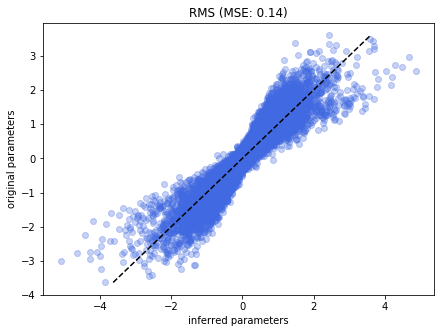

In [19]:
np.random.seed(1234)
p_rms = np.random.normal(0,1,N*N+N)
s = np.zeros(N*N+N)
### PARAMS
Steps = 400
l_r = 0.05
beta = 0.9
eps = 10**(-8)

LAMBDA = 0.001

for i in tqdm(range(Steps)):
    g = parralel_grad(p_rms,S_split,C,C_dot,gamma) - LAMBDA*p_rms
    s = beta * s + (1-beta)*g*g
    p_rms += l_r*g/np.sqrt(s+eps)                                      
    

print('MSE: ',np.sum((p_rms-p_real)**2))      
#plt.plot(ris)
plt.figure(figsize=(7,5))
plt.plot(p_rms,p_real,'o',alpha = 0.3,color='royalblue')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='black')
plt.title('RMS (MSE: '+str(np.mean((p_rms-p_real)**2))[:4]+')')

plt.xlabel("inferred parameters")
plt.ylabel("original parameters")
plt.savefig('02.png',dpi=200)

### Comparison between medium magnetization per site

In [20]:
np.random.seed(123)
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)
p_rand = np.concatenate((J.flatten(),h))

In [21]:
steps = 100_000

S_rms = simulation(N,p_rms,gamma,steps,dt)
S_mom = simulation(N,p_mom,gamma,steps,dt)
S_rand = simulation(N,p_rand,gamma,steps,dt)
S_real = simulation(N,p_real,gamma,steps,dt)


M = np.mean(S, axis = 1)
M_mom = np.mean(S_mom, axis = 1)
M_rms = np.mean(S_rms, axis = 1)
M_rand = np.mean(S_rand, axis = 1)
M_real = np.mean(S_real, axis = 1)

sigma = np.std(S, axis = 1)/np.sqrt(steps)

100%|██████████| 99999/99999 [00:05<00:00, 17449.05it/s]


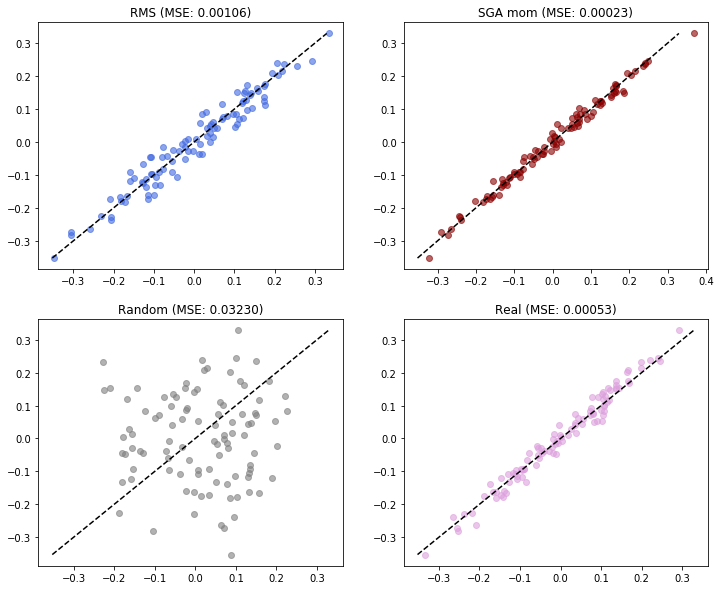

In [22]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(M_rms,M,'o',alpha = 0.6,color='royalblue')
axs[0, 0].set_title('RMS (MSE: '+str(np.mean((M_rms-M)**2))[:7]+')')
axs[0, 1].plot(M_mom,M,'o',alpha = 0.6,color='darkred')
axs[0, 1].set_title('SGA mom (MSE: '+str(np.mean((M_mom-M)**2))[:7]+')')
axs[1, 0].plot(M_rand,M,'o',alpha = 0.6,color='grey')
axs[1, 0].set_title('Random (MSE: '+str(np.mean((M_rand-M)**2))[:7]+')')
axs[1, 1].plot(M_real,M,'o',alpha = 0.6,color ='plum')
axs[1, 1].set_title('Real (MSE: '+str(np.mean((M_real-M)**2))[:7]+')')


for ax in axs.flat:
    ax.plot([min(M),max(M)],[min(M),max(M)],'--',color ='black')

plt.savefig('03.png',dpi=200)    

### Comparison between correlation matrix

In [23]:
C_o = C_and_Cdot(S,dt)[0].flatten()
C_mom = C_and_Cdot(S_mom,dt)[0].flatten()
C_rms = C_and_Cdot(S_rms,dt)[0].flatten()
C_rand = C_and_Cdot(S_rand,dt)[0].flatten()
C_real = C_and_Cdot(S_real,dt)[0].flatten()

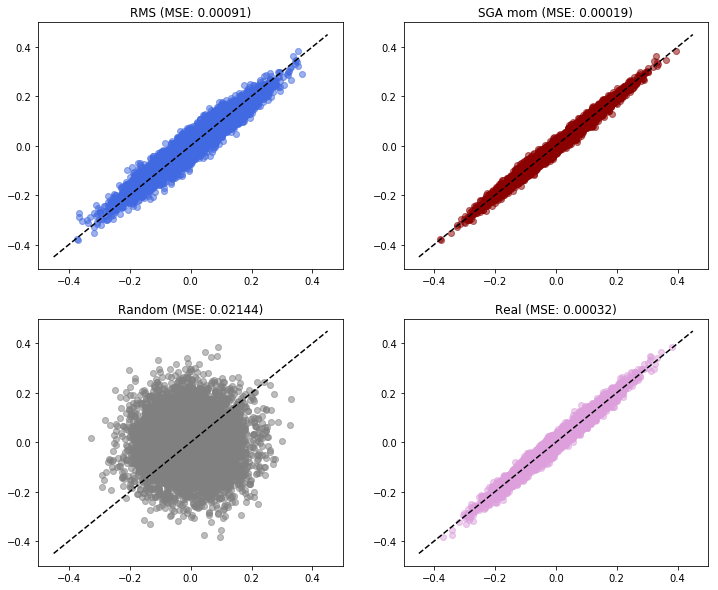

In [24]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(C_rms,C_o,'o',alpha = 0.3,color='royalblue')
axs[0, 0].set_title('RMS (MSE: '+str(np.mean((C_rms-C_o)**2))[:7]+')')
axs[0, 1].plot(C_mom,C_o,'o',alpha = 0.3,color='darkred')
axs[0, 1].set_title('SGA mom (MSE: '+str(np.mean((C_mom-C_o)**2))[:7]+')')
axs[1, 0].plot(C_rand,C_o,'o',alpha = 0.3,color='grey')
axs[1, 0].set_title('Random (MSE: '+str(np.mean((C_rand-C_o)**2))[:7]+')')
axs[1, 1].plot(C_real,C_o,'o',alpha = 0.3,color='plum')
axs[1, 1].set_title('Real (MSE: '+str(np.mean((C_real-C_o)**2))[:7]+')')


for ax in axs.flat:
    ax.plot([-0.45,0.45],[-0.45,0.45],'--',color ='black')
    ax.set_ylim(-0.5,0.5)
    ax.set_xlim(-0.5,0.5)
    
plt.savefig('04.png',dpi=200)

## 1000 spins and 100000 steps

In [25]:
#del S,S_rms,S_mom,S_rand,S_real
np.random.seed(201098)

N = 1000
#########################################
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)

p_real = np.concatenate((J.flatten(),h))
##########################################
gamma = 1
steps = 100_000
dt = 0.1
##########################################
##SIMULATION
np.random.seed(12345)
S = simulation(N,p_real,gamma,steps,dt)


C,C_dot = C_and_Cdot(S,dt)
#-----------------------n cores------------------------------------#
n_cores = 10 #10 is the best

S_split = np.array_split(S,n_cores,axis = 1)
#del S

100%|██████████| 99999/99999 [00:15<00:00, 6641.37it/s]


### Optimization

### GA with momentum

100%|██████████| 400/400 [15:30<00:00,  2.33s/it]


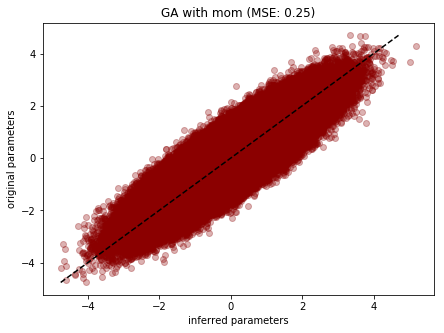

In [26]:
np.random.seed(2010)
p_mom = np.random.normal(0,1,N*N+N)
v = np.zeros(N*N+N)
### PARAMS
Steps = 400
l_r = np.linspace(0.1,0.001,Steps)
fric = 0.9

for i in tqdm(range(Steps)):
    g = parralel_grad(p_mom,S_split,C,C_dot,gamma)
    v = fric*v + l_r[i] * g
    p_mom += v
      
plt.figure(figsize=(7,5))
plt.plot(p_mom,p_real,'o',alpha = 0.3,color='darkred')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='black')
plt.title('GA with mom (MSE: '+str(np.mean((p_mom-p_real)**2))[:4]+')')
plt.xlabel("inferred parameters")
plt.ylabel("original parameters")
plt.savefig('05.png',dpi=200)

### RMS PROP + regularization

100%|██████████| 400/400 [15:37<00:00,  2.34s/it]


MSE:  257821.79639624193


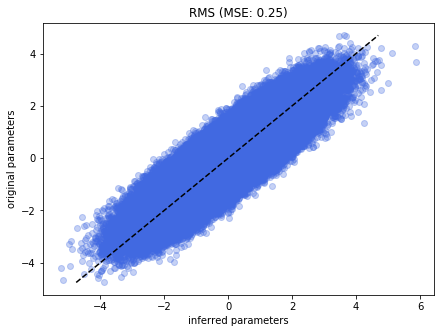

In [27]:
np.random.seed(1234)
p_rms = np.random.normal(0,1,N*N+N)
s = np.zeros(N*N+N)
### PARAMS
Steps = 400
l_r = 0.05
beta = 0.9
eps = 10**(-8)

LAMBDA = 0.002

for i in tqdm(range(Steps)):
    g = parralel_grad(p_rms,S_split,C,C_dot,gamma) - LAMBDA*p_rms
    s = beta * s + (1-beta)*g*g
    p_rms += l_r*g/np.sqrt(s+eps)                                      
    

print('MSE: ',np.sum((p_rms-p_real)**2))      
plt.figure(figsize=(7,5))
plt.plot(p_rms,p_real,'o',alpha = 0.3,color='royalblue')
plt.plot([min(p_real),max(p_real)],[min(p_real),max(p_real)],'--',color ='black')
plt.title('RMS (MSE: '+str(np.mean((p_rms-p_real)**2))[:4]+')')

plt.xlabel("inferred parameters")
plt.ylabel("original parameters")
plt.savefig('06.png',dpi=200)

### Comparison between medium magnetization per site

In [28]:
np.random.seed(123)
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)
p_rand = np.concatenate((J.flatten(),h))

In [29]:
steps = 100_000

S_rms = simulation(N,p_rms,gamma,steps,dt)
S_mom = simulation(N,p_mom,gamma,steps,dt)
S_rand = simulation(N,p_rand,gamma,steps,dt)
S_real = simulation(N,p_real,gamma,steps,dt)


M = np.mean(S, axis = 1)
M_mom = np.mean(S_mom, axis = 1)
M_rms = np.mean(S_rms, axis = 1)
M_rand = np.mean(S_rand, axis = 1)
M_real = np.mean(S_real, axis = 1)

sigma = np.std(S, axis = 1)/np.sqrt(steps)

100%|██████████| 99999/99999 [00:12<00:00, 7852.40it/s]


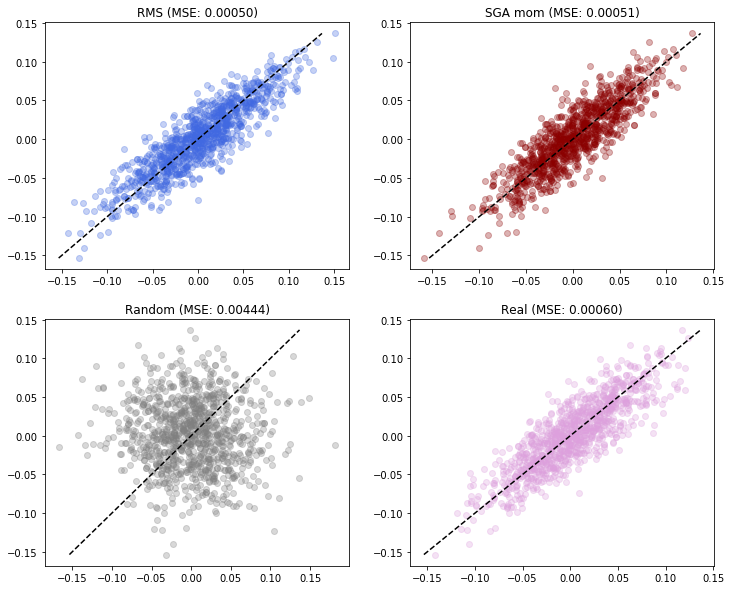

In [30]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(M_rms,M,'o',alpha = 0.3,color='royalblue')
axs[0, 0].set_title('RMS (MSE: '+str(np.mean((M_rms-M)**2))[:7]+')')
axs[0, 1].plot(M_mom,M,'o',alpha = 0.3,color='darkred')
axs[0, 1].set_title('SGA mom (MSE: '+str(np.mean((M_mom-M)**2))[:7]+')')
axs[1, 0].plot(M_rand,M,'o',alpha = 0.3,color='grey')
axs[1, 0].set_title('Random (MSE: '+str(np.mean((M_rand-M)**2))[:7]+')')
axs[1, 1].plot(M_real,M,'o',alpha = 0.3,color ='plum')
axs[1, 1].set_title('Real (MSE: '+str(np.mean((M_real-M)**2))[:7]+')')


for ax in axs.flat:
    ax.plot([min(M),max(M)],[min(M),max(M)],'--',color ='black')

plt.savefig('07.png',dpi=200)    

### Comparison between correlation matrix

In [31]:
C_o = C_and_Cdot(S,dt)[0].flatten()
C_mom = C_and_Cdot(S_mom,dt)[0].flatten()
C_rms = C_and_Cdot(S_rms,dt)[0].flatten()
C_rand = C_and_Cdot(S_rand,dt)[0].flatten()
C_real = C_and_Cdot(S_real,dt)[0].flatten()

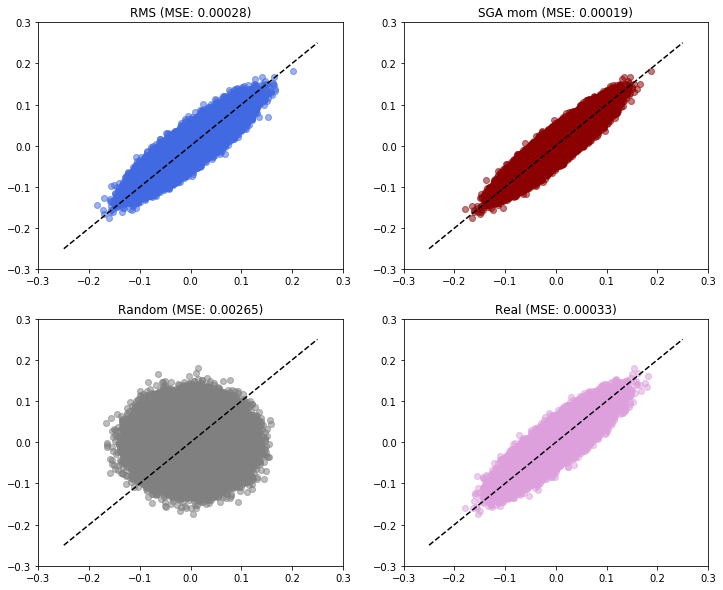

In [33]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(C_rms,C_o,'o',alpha = 0.3,color='royalblue')
axs[0, 0].set_title('RMS (MSE: '+str(np.mean((C_rms-C_o)**2))[:7]+')')
axs[0, 1].plot(C_mom,C_o,'o',alpha = 0.3,color='darkred')
axs[0, 1].set_title('SGA mom (MSE: '+str(np.mean((C_mom-C_o)**2))[:7]+')')
axs[1, 0].plot(C_rand,C_o,'o',alpha = 0.3,color='grey')
axs[1, 0].set_title('Random (MSE: '+str(np.mean((C_rand-C_o)**2))[:7]+')')
axs[1, 1].plot(C_real,C_o,'o',alpha = 0.3,color='plum')
axs[1, 1].set_title('Real (MSE: '+str(np.mean((C_real-C_o)**2))[:7]+')')


for ax in axs.flat:
    ax.plot([-0.25,0.25],[-0.25,0.25],'--',color ='black')
    ax.set_ylim(-0.3,0.3)
    ax.set_xlim(-0.3,0.3)
    
plt.savefig('08.png',dpi=200)

## Real dataset

In [ ]:
del S,S_rms,S_mom,S_rand,S_real

In [ ]:
def plot_S(S): 
    plt.figure(figsize=(15,5))
    plt.imshow(S,aspect = 'auto', cmap = 'binary', interpolation = 'None')
    plt.title(S.shape)

In [ ]:
S = np.load('59_neurons_60k_steps.npy').astype('double')
#-----------------------TRICK-------------------------------------#
#S = np.concatenate((S,S,S,S,S,S,S),axis=1)
#-----------------------params------------------------------------#
gamma = 1
dt = 1/30
N, steps = S.shape

C,C_dot = C_and_Cdot(S,dt)
#-----------------------n cores------------------------------------#
n_cores = 5 #10 is the best

S_split = np.array_split(S,n_cores,axis = 1)
#del S
print(S.shape)
plot_S(S)

### Optimization

### GA with momentum

In [ ]:
np.random.seed(123)
dt = 1/30
gamma = 1

h = np.arctanh(np.mean(S, axis = 1)) 
J = np.zeros((N, N))
p_mom = np.concatenate((J.flatten(),h))

#p_mom = np.random.normal(0,0.1,N*N+N)
#v = np.zeros(N*N+N)
### PARAMS
Steps = 1000
l_r = np.linspace(0.3,0.01,Steps)
fric = 0.9
LAMBDA = 0.001

for i in tqdm(range(Steps)):
    g = parralel_grad(p_mom,S_split,C,C_dot,gamma) - LAMBDA*p_mom
    v = fric*v + l_r[i] * g
    p_mom += v
      
S_mom = simulation(N,p_mom,gamma,steps,dt)
plot_S(S_mom)
plot_S(S)

### RMS PROP + regularization

In [ ]:
np.random.seed(123)
p_rms = np.random.normal(0,0.1,N*N+N)
s = np.zeros(N*N+N)
### PARAMS
Steps = 1000
l_r = np.linspace(0.3,0.01,Steps)
beta = 0.9
eps = 10**(-8)

LAMBDA = 0.001

for i in tqdm(range(Steps)):
    g = parralel_grad(p_rms,S_split,C,C_dot,gamma) - LAMBDA*p_rms
    s = beta * s + (1-beta)*g*g
    p_rms += l_r[i]*g/np.sqrt(s+eps)                                      
    

S_rms = simulation(N,p_rms,gamma,steps,dt)
plot_S(S_rms)
plot_S(S)

### Comparison between medium magnetization per site

In [ ]:
np.random.seed(123)
J = np.random.normal(0,1,(N,N))
np.fill_diagonal(J,0)
h = np.random.normal(0,1,N)
p_rand = np.concatenate((J.flatten(),h))

In [ ]:
#steps = 100_000

S_rms = simulation(N,p_rms,gamma,steps,dt)
S_mom = simulation(N,p_mom,gamma,steps,dt)
S_rand = simulation(N,p_rand,gamma,steps,dt)


M = np.mean(S, axis = 1)
M_mom = np.mean(S_mom, axis = 1)
M_rms = np.mean(S_rms, axis = 1)
M_rand = np.mean(S_rand, axis = 1)


In [ ]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(M_rms,M,'o',alpha = 0.3)
axs[0, 0].set_title('RMS (MSE: '+str(np.sum((M_rms-M)**2))[:5]+')')
axs[0, 1].plot(M_mom,M,'o',alpha = 0.3)
axs[0, 1].set_title('SGA mom (MSE: '+str(np.sum((M_mom-M)**2))[:5]+')')
axs[1, 0].plot(M_rand,M,'o',alpha = 0.3)
axs[1, 0].set_title('Random (MSE: '+str(np.sum((M_rand-M)**2))[:5]+')')
#axs[1, 1].plot(M_real,M,'o',alpha = 0.3)
#axs[1, 1].set_title('Real (MSE: '+str(np.sum((M_real-M)**2))[:5]+')')


for ax in axs.flat[:-1]:
    ax.plot([min(M),max(M)],[min(M),max(M)],'--',color ='red')


### Comparison between correlation matrix

In [ ]:
C_o = C_and_Cdot(S,dt)[0].flatten()
C_mom = C_and_Cdot(S_mom,dt)[0].flatten()
C_rms = C_and_Cdot(S_rms,dt)[0].flatten()
C_rand = C_and_Cdot(S_rand,dt)[0].flatten()

In [ ]:
fig, axs = plt.subplots(2, 2 ,figsize=(12,10))
axs[0, 0].plot(C_rms,C_o,'o',alpha = 0.3)
axs[0, 0].set_title('RMS (MSE: '+str(np.sum((C_rms-C_o)**2))[:5]+')')
axs[0, 1].plot(C_mom,C_o,'o',alpha = 0.3)
axs[0, 1].set_title('SGA mom (MSE: '+str(np.sum((C_mom-C_o)**2))[:5]+')')
axs[1, 0].plot(C_rand,C_o,'o',alpha = 0.3)
axs[1, 0].set_title('Random (MSE: '+str(np.sum((C_rand-C_o)**2))[:5]+')')
#axs[1, 1].plot(C_real,C_o,'o',alpha = 0.3)
#axs[1, 1].set_title('Real (MSE: '+str(np.sum((C_real-C_o)**2))[:5]+')')


for ax in axs.flat[:-1]:
    ax.plot([min(C_o),max(C_o)],[min(C_o),max(C_o)],'--',color ='red')
    #ax.set_ylim(-0.25,0.25)
    #ax.set_xlim(-0.25,0.25)